In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [16]:
mnist = fetch_openml('mnist_784', version=1)

In [17]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [18]:
for k in mnist.keys():
    print(k)
    print(mnist[k])
    print("\n\n\n")

data
       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995       0       0       0       0       0       0       0       0       0   
69996       0       0       0       0       0       0       0       0       0   
69997       0       0       0       0       0       0       0       0       0   
69998       0       0       0       0       0       0       0       0       0   
69999       0       0       0       0       0       0       0       0       0   

       pixel10  ...  p

In [19]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [20]:
y.shape

(70000,)

In [21]:
type(X)

pandas.core.frame.DataFrame

In [22]:
type(y)

pandas.core.series.Series

In [23]:
some_digit = X.loc[0]

In [24]:
some_digit_image = np.array(some_digit).reshape(28, 28)

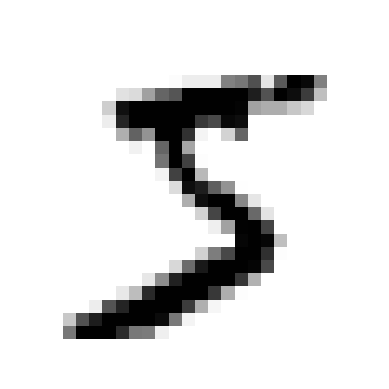

In [25]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [26]:
y.loc[0]

'5'

In [27]:
y = y.astype(np.uint8)

# Splitting Test Set

In [28]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [30]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [31]:
sgd_clf.predict([some_digit])

/home/nic0der/Documents/ml_book/own_work/venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [32]:
#Own made cross validation

skfolds = StratifiedKFold(n_splits=3, random_state=None)
for train_index, test_index in skfolds.split(X_train, y_train_5):
     clone_clf = clone(sgd_clf)
     X_train_folds = X_train.loc[train_index]
     y_train_folds = y_train_5.loc[train_index]
     X_test_fold = X_train.loc[test_index]
     y_test_fold = y_train_5.loc[test_index]
    
     clone_clf.fit(X_train_folds, y_train_folds)
     y_pred = clone_clf.predict(X_test_fold)
     n_correct = sum(y_pred == y_test_fold)
     print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.95035
0.96035
0.9604


In [33]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [34]:
# Dumb classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


-----

# Confusion Matrix

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [38]:
# y_train_perfect_predictions = y_train_5 # pretend we reached perfection
# confusion_matrix(y_train_5, y_train_perfect_predictions)
# array([[54579,     0],
#        [    0,  5421]])

In [39]:
#test 2

In [40]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

np.float64(0.8370879772350012)

In [41]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

In [42]:
f1_score(y_train_5, y_train_pred)


np.float64(0.7325171197343847)

In [43]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/home/nic0der/Documents/ml_book/own_work/venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [44]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [45]:
y_some_digit_pred

array([ True])

In [46]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [47]:
# Crossvalidation with decision_function instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [49]:
# precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [50]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown 
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

In [53]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

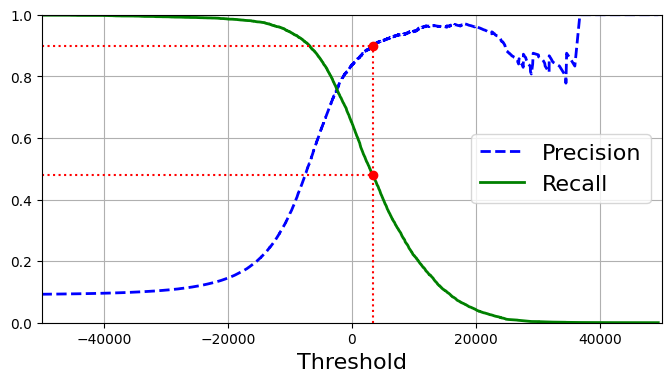

In [55]:
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

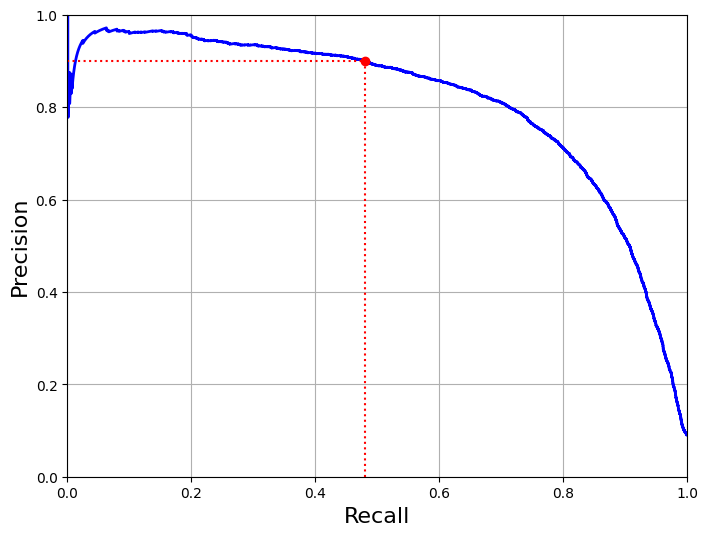

In [57]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [58]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [59]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [60]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [61]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

In [ ]:
#If someone says “let’s reach 99% precision,” you should ask, “at
#what recall?”